In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import random
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import OrderedDict, defaultdict


import torch
import torchvision.models as models
from transformers import get_scheduler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# load training and test dataset
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fakeddit_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fakeddit_test.csv')

In [ ]:
# load the different feature represenations for training dataset
file_path_fused_train = '/content/drive/MyDrive/Colab Notebooks/fused_features_train.pt'
file_path_text_train = '/content/drive/MyDrive/Colab Notebooks/text_features_train.pt'
file_path_image_train = '/content/drive/MyDrive/Colab Notebooks/image_features_train.pt'

fused_features_train = torch.load(file_path_fused_train)
text_features_train = torch.load(file_path_text_train)
image_features_train = torch.load(file_path_image_train)

In [ ]:
# load the different feature represenations for test dataset
file_path_fused_test = '/content/drive/MyDrive/Colab Notebooks/fused_features_test.pt'
file_path_text_test = '/content/drive/MyDrive/Colab Notebooks/text_features_test.pt'
file_path_image_test = '/content/drive/MyDrive/Colab Notebooks/image_features_test.pt'

fused_features_test = torch.load(file_path_fused_test)
text_features_test = torch.load(file_path_text_test)
image_features_test = torch.load(file_path_image_test)

In [ ]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    print('available')
    torch.cuda.manual_seed_all(random_seed)

available


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define the class of the neural network
class Classifier(nn.Module):
    def __init__(self, arch, dropout_prob=0.2):
        super(Classifier, self).__init__()
        self.flatten = nn.Flatten()
        layers = []
        counts = defaultdict(int)

        def add(name: str, layer: nn.Module) -> None:
            layers.append((f"{name}{counts[name]}", layer))
            counts[name] += 1

        in_channels = arch.pop(0)
        out_channels = arch.pop(-1)
        for x in arch:
            if x != 'D':
                # linear layers
                add("linear", nn.Linear(in_channels, x))
                add("relu", nn.ReLU())
                in_channels = x
            else:
                # dropout
                add("dropout", nn.Dropout(dropout_prob))
        self.linear_relu_stack = nn.Sequential(OrderedDict(layers))
        self.out_layer = nn.Linear(in_channels, out_channels)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        logits = self.out_layer(x)
        return logits

In [ ]:
def get_label_name(n):
    if n == 2:
        return '2_way_label'
    elif n == 3:
        return '3_way_label'
    elif n == 6:
        return '6_way_label'

In [ ]:
#Custom pipeline for training and testing of the neural network
class CustomPipeline():
    def __init__(self, arch, learning_rate, batch_size, label):
        super(CustomPipeline, self).__init__()
        self.model = Classifier(arch)
        self.model.to(device)
        print(self.model)
        self.criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.label = label

    def set_learning_rate(self, learning_rate):
        self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)

    def prepare_training_dataset(self, fused_features, dataframe):
        label_name = get_label_name(self.label)
        X_train, X_validation, Y_train, Y_validation = train_test_split(fused_features, dataframe[label_name], test_size=0.2, random_state=random_seed)

        train_data = X_train.to(device)  # input data tensor
        target_labels = torch.tensor(Y_train.tolist()).to(device)  # target labels tensor
        target_labels = target_labels.squeeze()
        print(target_labels.shape)

        # Create a TensorDataset from input_data and target_labels
        dataset = TensorDataset(train_data, target_labels)
        # Create a DataLoader to iterate over batches of data
        self.train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        validation_data = X_validation.to(device) # input data tensor
        target_labels_validate = torch.tensor(Y_validation.tolist()).to(device)  # target labels tensor
        target_labels_validate = target_labels_validate.squeeze()
        validation_dataset = TensorDataset(validation_data, target_labels_validate)
        self.validation_loader = DataLoader(validation_dataset, batch_size=self.batch_size)

    def prepare_test_dataset(self, fused_features, dataframe):
        label_name = get_label_name(self.label)
        X_test = fused_features.to(device)  # input data tensor
        Y_test = dataframe[label_name]
        target_labels = torch.tensor(Y_test.tolist()).to(device)  # target labels tensor
        target_labels = target_labels.squeeze()
        # Create a TensorDataset from input_data and target_labels
        dataset = TensorDataset(X_test, target_labels)
        # Create a DataLoader to iterate over batches of data
        self.test_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return self.test_loader

    def validate(self, dataset):
        self.model.eval()
        total_samples = 0
        correct_predictions = 0
        total_loss = 0
        for inputs, targets in dataset:
            # Get the batch size

            batch_size = inputs.size(0)
            total_samples += batch_size

            with torch.no_grad():
                outputs = self.model(inputs)

            # Compute the loss
                loss = self.criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=-1) # because output is logit not probability
                correct_predictions += (predicted == targets).sum().item()
                total_loss += loss.item()
        validation_accuracy = correct_predictions / total_samples
        validation_loss = total_loss / len(dataset)
        return validation_accuracy, validation_loss

    def load_weights(self, weights):
        self.model.load_state_dict(weights)


    def test(self, dataset):
        self.model.eval()
        total_samples = 0
        correct_predictions = 0
        total_loss = 0
        pred_arr = np.array([])
        target_arr = np.array([])
        for inputs, targets in dataset:
            # Get the batch size

            batch_size = inputs.size(0)
            total_samples += batch_size

            with torch.no_grad():
                outputs = self.model(inputs)

            # Compute the loss
                loss = self.criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=-1) # because output is logit not probability
                pred_arr = np.hstack(
                    (pred_arr, predicted.cpu().numpy().squeeze())
                )
                target_arr = np.hstack(
                    (target_arr, targets.cpu().numpy().squeeze())
                )
                total_loss += loss.item()
        test_loss = total_loss / len(dataset)
        return test_loss, pred_arr, target_arr

    # Function to load scheduler for changing learning rate
    def decide_scheduler(self, schedule, train_steps):
        class FakeScheduler:
            def step():
                pass
        if schedule:
            lr_scheduler = get_scheduler(name="linear", optimizer=self.optimizer, num_warmup_steps=2, num_training_steps=train_steps)
            return lr_scheduler
        else:
            return FakeScheduler()

    def train(self, num_epochs, schedule=True):
        loss_list = []
        num_train_steps = num_epochs * len(self.train_loader)
        progress_bar = tqdm(range(num_train_steps))
        validation_accuracy_list = []
        train_accuracy_list = []
        validation_loss_list = []
        patience = 7
        best_accuracy = 0
        counter = 0
        stopped_epoch = 0


        lr_scheduler = self.decide_scheduler(schedule, num_train_steps)
        # Training loop
        for epoch in range(num_epochs):
            total_loss = 0.0
            total_samples = 0
            # set the model to training mode
            self.model.train()
            for inputs, targets in self.train_loader:
                self.optimizer.zero_grad()
                batch_size = inputs.size(0)
                total_samples += batch_size
                # Forward pass
                outputs = self.model(inputs)
                # Compute the loss
                loss = self.criterion(outputs, targets)
                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()
                lr_scheduler.step()
                self.optimizer.zero_grad()
                # Update the progress bar
                progress_bar.update(1)
                total_loss += loss.item()

            validation_accuracy, validation_loss = self.validate(self.validation_loader)
            validation_accuracy_list.append(validation_accuracy)
            validation_loss_list.append(validation_loss)

            train_accuracy, train_loss = self.validate(self.train_loader)
            train_accuracy_list.append(train_accuracy)

            loss_in_epoch = total_loss / len(self.train_loader)
            loss_list.append(loss_in_epoch)
            # Print the average loss for the epoch
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_in_epoch}, Train Accuracy: {train_accuracy*100}, Validation Loss: {validation_loss} Validation Accuracy: {validation_accuracy*100}")
            #for early stopping
            if validation_accuracy >= best_accuracy:
                best_accuracy = validation_accuracy
                counter = 0
                # Save the best model weights
                self.best_model_weights = self.model.state_dict()
                stopped_epoch = epoch
            else:
                counter += 1
                if counter >= patience:
                    self.model.load_state_dict(self.best_model_weights)
                    print("Early stopping triggered.")
                    break
        return validation_accuracy_list, validation_loss_list[0:stopped_epoch+1], loss_list[0:stopped_epoch+1]


In [ ]:
def generate_metrics(targets, predictions, val_loss, train_loss, num_of_labels, model):
    y_true, y_pred = targets, np.array(predictions)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Accuracy:", accuracy * 100)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    target_names = ['0', '1', '2']
    #Print the classifcation report for all the classes
    print(classification_report(y_true, y_pred, target_names=target_names))

    #Plot confusion matrix
    array = np.arange(num_of_labels)
    classes = array.astype(str)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {num_of_labels} way labels for {model}')
    plt.savefig(f'c_matrix_{num_of_labels}_way_{model}.png')
    plt.show()

    #Plot validation loss and training loss
    plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label='Validation Loss')
    plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epoch for {num_of_labels} way labels for {model}')
    plt.grid(True)
    plt.savefig(f'loss_graph_{num_of_labels}_way_{model}.png')
    plt.show()



### Train and test fused features for Multimodal dataset



In [ ]:
num_of_labels = 3

In [ ]:
#define the architecture
arch_fusion = [
    2816,
    'D',
    2816,
    'D',
    512,
    'D',
    128,
    # 'D',
    16,
    num_of_labels
    ]
batch_size = 64
learning_rate = 1e-4
num_of_epochs = 40

In [ ]:
#intialize piepline and prepare training data
fused_pipeline = CustomPipeline(arch_fusion, learning_rate, batch_size, num_of_labels)
fused_pipeline.prepare_training_dataset(fused_features_train, df_train)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear0): Linear(in_features=2816, out_features=2816, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=2816, out_features=512, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=128, out_features=16, bias=True)
    (relu3): ReLU()
  )
  (out_layer): Linear(in_features=16, out_features=3, bias=True)
)
torch.Size([2699])


In [ ]:
#train the model
validation_accuracy, validation_loss, training_loss = fused_pipeline.train(num_of_epochs)

  0%|          | 0/1720 [00:00<?, ?it/s]

Epoch [1/40], Loss: 0.8572967038598172, Train Accuracy: 58.391997035939234, Validation Loss: 0.8221037929708307 Validation Accuracy: 54.074074074074076
Epoch [2/40], Loss: 0.7496410206306813, Train Accuracy: 65.50574286772878, Validation Loss: 0.7528610825538635 Validation Accuracy: 58.666666666666664
Epoch [3/40], Loss: 0.6550411096839017, Train Accuracy: 70.32234160800297, Validation Loss: 0.7144500775770708 Validation Accuracy: 66.07407407407408
Epoch [4/40], Loss: 0.597924294859864, Train Accuracy: 75.84290477954798, Validation Loss: 0.6202704283324155 Validation Accuracy: 70.81481481481482
Epoch [5/40], Loss: 0.5540013278639594, Train Accuracy: 77.91774731381993, Validation Loss: 0.604337443004955 Validation Accuracy: 71.85185185185186
Epoch [6/40], Loss: 0.513333156358364, Train Accuracy: 77.73249351611709, Validation Loss: 0.647293743762103 Validation Accuracy: 70.51851851851852
Epoch [7/40], Loss: 0.5124615611031998, Train Accuracy: 81.28936643201186, Validation Loss: 0.5709905

Test Loss: 0.502871348099275
Accuracy: 78.19548872180451
Precision: 0.7802107357512691
Recall: 0.7819548872180451
F1 Score: 0.7804090352442301
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       390
           1       0.71      0.74      0.72        23
           2       0.74      0.69      0.71       252

    accuracy                           0.78       665
   macro avg       0.75      0.76      0.75       665
weighted avg       0.78      0.78      0.78       665



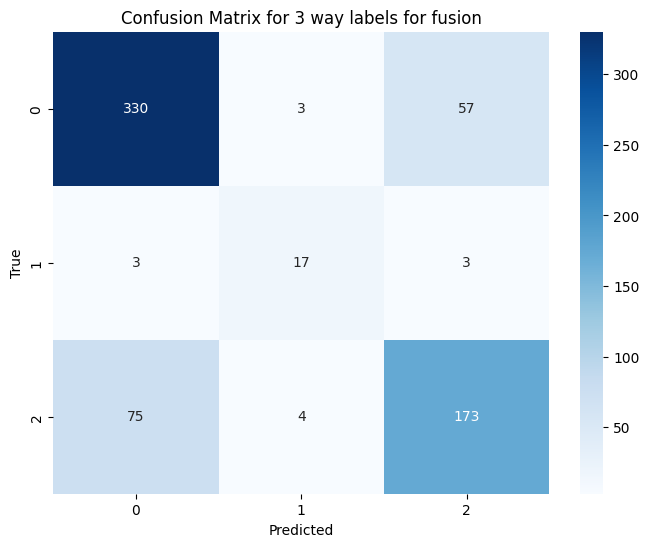

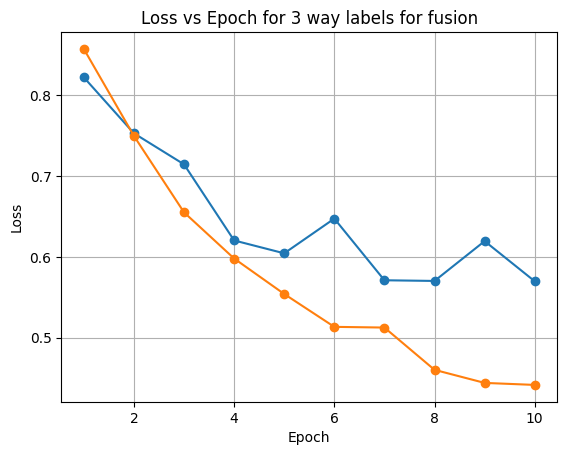

In [ ]:
#test the model
test_dataset = fused_pipeline.prepare_test_dataset(fused_features_test, df_test)
loss, predictions, targets = fused_pipeline.test(test_dataset)
print(f"Test Loss: {loss}")
generate_metrics(targets, predictions, validation_loss, training_loss, num_of_labels, 'fusion')

### Train and test fused features for image only input



In [ ]:
arch_image = [
    2048,
    'D',
    2048,
    'D',
    512,
    'D',
    128,
    #'D',
    16,
    num_of_labels
    ]
batch_size = 64
learning_rate = 1e-4
num_of_epochs = 60

In [ ]:
image_pipeline = CustomPipeline(arch_image, learning_rate, batch_size, num_of_labels)
image_pipeline.prepare_training_dataset(image_features_train, df_train)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear0): Linear(in_features=2048, out_features=2048, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=2048, out_features=512, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=128, out_features=16, bias=True)
    (relu3): ReLU()
  )
  (out_layer): Linear(in_features=16, out_features=3, bias=True)
)
torch.Size([2699])


In [ ]:
validation_accuracy, validation_loss, training_loss = image_pipeline.train(num_of_epochs)

  0%|          | 0/2580 [00:00<?, ?it/s]

Epoch [1/60], Loss: 0.8993904701499051, Train Accuracy: 58.391997035939234, Validation Loss: 0.838664401661266 Validation Accuracy: 54.074074074074076
Epoch [2/60], Loss: 0.786231417988622, Train Accuracy: 58.391997035939234, Validation Loss: 0.804656212980097 Validation Accuracy: 54.074074074074076
Epoch [3/60], Loss: 0.740495367105617, Train Accuracy: 66.98777324935162, Validation Loss: 0.7524030858820135 Validation Accuracy: 62.96296296296296
Epoch [4/60], Loss: 0.6877782400264296, Train Accuracy: 66.43201185624305, Validation Loss: 0.75709237835624 Validation Accuracy: 60.44444444444444
Epoch [5/60], Loss: 0.6634410377158675, Train Accuracy: 69.95183401259726, Validation Loss: 0.6937959627671675 Validation Accuracy: 65.77777777777779
Epoch [6/60], Loss: 0.6384892491407173, Train Accuracy: 71.76732123008522, Validation Loss: 0.6782871268012307 Validation Accuracy: 66.37037037037037
Epoch [7/60], Loss: 0.6102238193500874, Train Accuracy: 73.36050389032975, Validation Loss: 0.66732023

Test Loss: 0.8806063641201366
Accuracy: 64.06015037593986
Precision: 0.6816741003295314
Recall: 0.6406015037593985
F1 Score: 0.6441177061317176
              precision    recall  f1-score   support

           0       0.79      0.57      0.66       390
           1       0.62      0.65      0.64        23
           2       0.53      0.75      0.62       252

    accuracy                           0.64       665
   macro avg       0.65      0.66      0.64       665
weighted avg       0.68      0.64      0.64       665



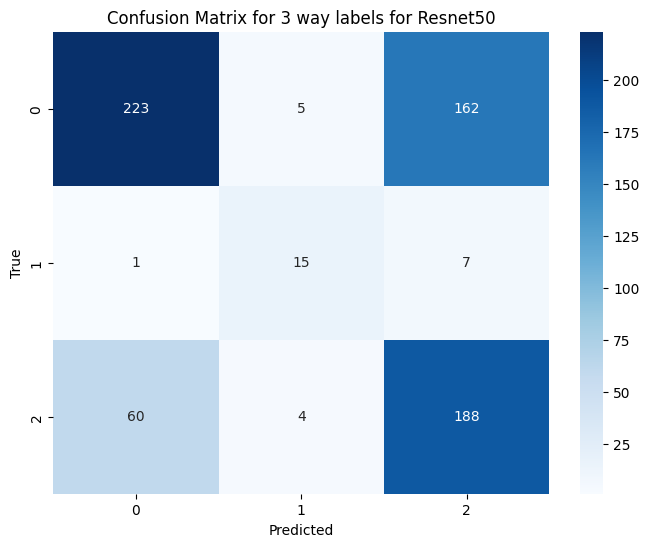

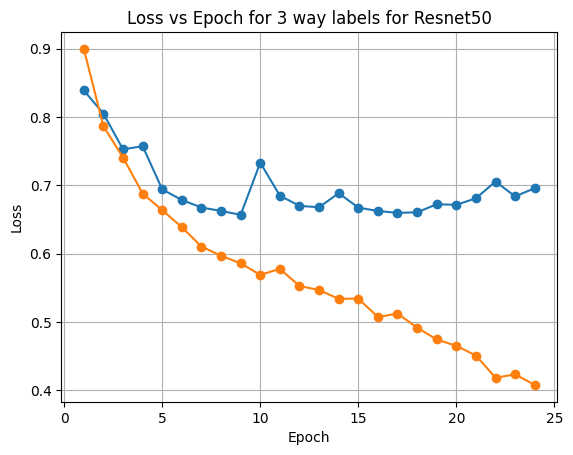

In [ ]:
test_dataset = image_pipeline.prepare_test_dataset(image_features_test, df_test)
loss, predictions, targets = image_pipeline.test(test_dataset)
print(f"Test Loss: {loss}")
generate_metrics(targets, predictions,validation_loss, training_loss, num_of_labels, 'Resnet50')

### Train and test fused features for text only input



In [ ]:
arch_text = [
    768,
    'D',
    768,
    'D',
    512,
    'D',
    128,
    # 'D',
    16,
    num_of_labels
    ]
batch_size = 64
learning_rate = 1e-3
num_of_epochs = 60

In [ ]:
text_pipeline = CustomPipeline(arch_text, learning_rate, batch_size, num_of_labels)
text_pipeline.prepare_training_dataset(text_features_train, df_train)

Classifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear0): Linear(in_features=768, out_features=768, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=768, out_features=512, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=128, out_features=16, bias=True)
    (relu3): ReLU()
  )
  (out_layer): Linear(in_features=16, out_features=3, bias=True)
)
torch.Size([2699])


In [ ]:
validation_accuracy, validation_loss, training_loss = text_pipeline.train(num_of_epochs)

  0%|          | 0/2580 [00:00<?, ?it/s]

Epoch [1/60], Loss: 0.7804794020430986, Train Accuracy: 69.98888477213782, Validation Loss: 0.6877303882078691 Validation Accuracy: 65.33333333333333
Epoch [2/60], Loss: 0.6054600366326266, Train Accuracy: 74.13856984068174, Validation Loss: 0.6272481246428057 Validation Accuracy: 70.66666666666667
Epoch [3/60], Loss: 0.561073046090991, Train Accuracy: 75.6947017413857, Validation Loss: 0.7057311047207225 Validation Accuracy: 67.85185185185185
Epoch [4/60], Loss: 0.5240948553695235, Train Accuracy: 81.43756947017414, Validation Loss: 0.5765921554782174 Validation Accuracy: 74.37037037037038
Epoch [5/60], Loss: 0.49153578697248945, Train Accuracy: 82.91959985179696, Validation Loss: 0.576147897676988 Validation Accuracy: 74.07407407407408
Epoch [6/60], Loss: 0.4468287998853728, Train Accuracy: 84.69803630974435, Validation Loss: 0.5696796043352648 Validation Accuracy: 74.07407407407408
Epoch [7/60], Loss: 0.4179809051890706, Train Accuracy: 87.43979251574657, Validation Loss: 0.57389940

Test Loss: 0.8976966792886908
Accuracy: 73.38345864661655
Precision: 0.7568422465496657
Recall: 0.7338345864661654
F1 Score: 0.738343779829848
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       390
           1       0.52      0.70      0.59        23
           2       0.63      0.77      0.70       252

    accuracy                           0.73       665
   macro avg       0.67      0.73      0.69       665
weighted avg       0.76      0.73      0.74       665



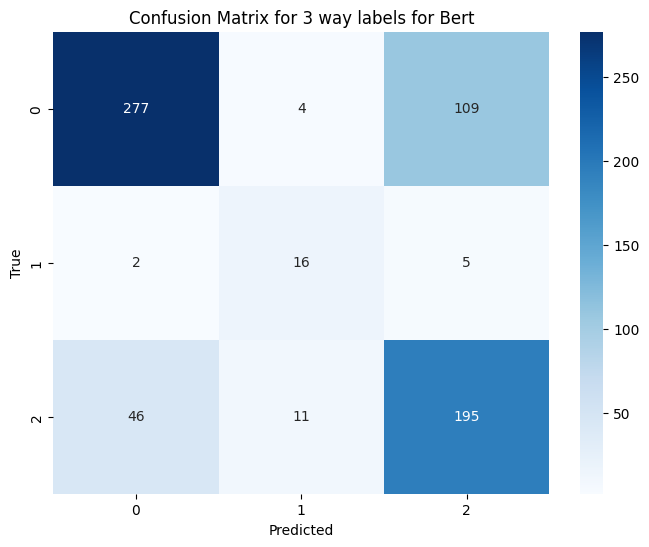

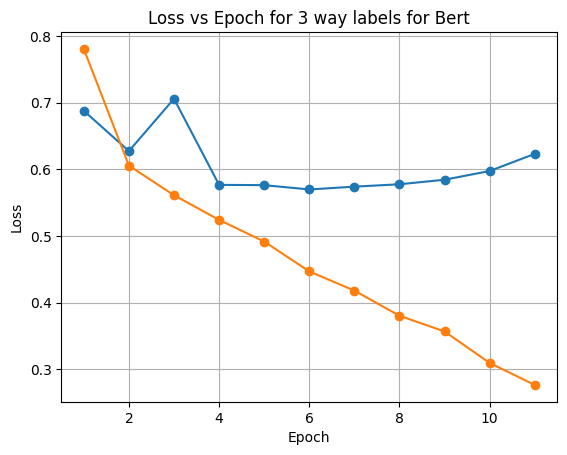

In [ ]:
test_dataset = text_pipeline.prepare_test_dataset(text_features_test, df_test)
loss, predictions, targets = text_pipeline.test(test_dataset)
print(f"Test Loss: {loss}")
generate_metrics(targets, predictions,validation_loss, training_loss, num_of_labels, 'Bert')